In [1]:
import cv2
import math
import random
import numpy as np
import os.path as osp
import os
from PIL import Image
from prepare_data import degradations as degradations
from prepare_data.utils import setup_logger
import torch
import torch.utils.data as data
from torchvision import transforms
from torchvision.transforms.functional import (adjust_brightness, adjust_contrast, 
                                        adjust_hue, adjust_saturation, normalize)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


In [9]:
class FFHQDegraDataset(data.Dataset):
    def __init__(self, opt):
        self.image_folder = opt['image_folder']
        self.image_paths = []
        for root, _, files in os.walk(self.image_folder):
            for file in files:
                if file.endswith(('png', 'jpg', 'jpeg')):
                    self.image_paths.append(osp.join(root, file))
        self.opt = opt

        # data augmentation
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5 if opt['use_hflip'] else 0),  
            transforms.RandomVerticalFlip(p=0.5 if opt['use_vflip'] else 0),   
            transforms.RandomRotation(degrees=opt.get('rotate', 0)),   
        ])

        self.mean = opt['mean']
        self.std = opt['std']
        self.out_size = opt['out_size']

        # degradation configurations
        self.blur_kernel_size = opt['blur_kernel_size']
        self.kernel_list = opt['kernel_list']
        self.kernel_prob = opt['kernel_prob']
        self.blur_sigma = opt['blur_sigma']
        self.downsample_range = opt['downsample_range']
        self.noise_range = opt['noise_range']
        self.jpeg_range = opt['jpeg_range']

        # color jitter
        self.color_jitter_prob = opt.get('color_jitter_prob')
        self.color_jitter_pt_prob = opt.get('color_jitter_pt_prob')
        self.color_jitter_shift = opt.get('color_jitter_shift', 20)
        # to gray
        self.gray_prob = opt.get('gray_prob')

        logger = setup_logger()
        logger.info(f'Blur: blur_kernel_size {self.blur_kernel_size}, sigma: [{", ".join(map(str, self.blur_sigma))}]')
        logger.info(f'Downsample: downsample_range [{", ".join(map(str, self.downsample_range))}]')
        logger.info(f'Noise: [{", ".join(map(str, self.noise_range))}]')
        logger.info(f'JPEG compression: [{", ".join(map(str, self.jpeg_range))}]')

        if self.color_jitter_prob is not None:
            logger.info(f'Use random color jitter. Prob: {self.color_jitter_prob}, shift: {self.color_jitter_shift}')
        if self.gray_prob is not None:
            logger.info(f'Use random gray. Prob: {self.gray_prob}')

        self.color_jitter_shift /= 255.

    @staticmethod
    def color_jitter(img, shift):
        """jitter color: randomly jitter the RGB values, in numpy formats"""
        jitter_val = np.random.uniform(-shift, shift, 3).astype(np.float32)
        img = img + jitter_val
        img = np.clip(img, 0, 1)
        return img

    @staticmethod
    def color_jitter_pt(img, brightness, contrast, saturation, hue):
        """jitter color: randomly jitter the brightness, contrast, saturation, and hue, in torch Tensor formats"""
        fn_idx = torch.randperm(4)
        for fn_id in fn_idx:
            if fn_id == 0 and brightness is not None:
                brightness_factor = torch.tensor(1.0).uniform_(brightness[0], brightness[1]).item()
                img = adjust_brightness(img, brightness_factor)

            if fn_id == 1 and contrast is not None:
                contrast_factor = torch.tensor(1.0).uniform_(contrast[0], contrast[1]).item()
                img = adjust_contrast(img, contrast_factor)

            if fn_id == 2 and saturation is not None:
                saturation_factor = torch.tensor(1.0).uniform_(saturation[0], saturation[1]).item()
                img = adjust_saturation(img, saturation_factor)

            if fn_id == 3 and hue is not None:
                hue_factor = torch.tensor(1.0).uniform_(hue[0], hue[1]).item()
                img = adjust_hue(img, hue_factor)
        return img

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        # random horizontal flip, rotation

        img = self.transform(img)

        # Convert image to numpy array
        img_gt = np.array(img).astype(np.float32)/255.0        
        
        h, w, _ = img_gt.shape
        
        # ------------------------ generate lq image ------------------------ #
        # blur
        kernel = degradations.random_mixed_kernels(
            self.kernel_list,
            self.kernel_prob,
            self.blur_kernel_size,
            self.blur_sigma,
            self.blur_sigma, [-math.pi, math.pi],
            noise_range=None)
        img_lq = cv2.filter2D(img_gt, -1, kernel)
        # downsample
        scale = np.random.uniform(self.downsample_range[0], self.downsample_range[1])
        img_lq = cv2.resize(img_lq, (int(w // scale), int(h // scale)), interpolation=cv2.INTER_LINEAR)
        # noise
        if self.noise_range is not None:
            img_lq = degradations.random_add_gaussian_noise(img_lq, self.noise_range)
        # jpeg compression
        if self.jpeg_range is not None:
            img_lq = degradations.random_add_jpg_compression(img_lq, self.jpeg_range)

        # resize to original size
        img_lq = cv2.resize(img_lq, (w, h), interpolation=cv2.INTER_LINEAR)

        # random color jitter (only for lq)
        if self.color_jitter_prob is not None and (np.random.uniform() < self.color_jitter_prob):
            img_lq = self.color_jitter(img_lq, self.color_jitter_shift)
        # random to gray (only for lq)
        if self.gray_prob is not None and np.random.uniform() < self.gray_prob:
            img_lq = cv2.cvtColor(img_lq, cv2.COLOR_BGR2GRAY)
            img_lq = np.tile(img_lq[:, :, None], [1, 1, 3])
            if self.opt.get('gt_gray'):  # whether convert GT to gray images
                img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2GRAY)
                img_gt = np.tile(img_gt[:, :, None], [1, 1, 3])  # repeat the color channels

        # BGR to RGB, HWC to CHW, numpy to tensor
        img_gt, img_lq = torch.from_numpy(img_gt).permute(2, 0, 1).float(), torch.from_numpy(img_lq).permute(2, 0, 1).float()

        # random color jitter (pytorch version) (only for lq)
        if self.color_jitter_pt_prob is not None and (np.random.uniform() < self.color_jitter_pt_prob):
            brightness = self.opt.get('brightness', (0.5, 1.5))
            contrast = self.opt.get('contrast', (0.5, 1.5))
            saturation = self.opt.get('saturation', (0, 1.5))
            hue = self.opt.get('hue', (-0.1, 0.1))
            img_lq = self.color_jitter_pt(img_lq, brightness, contrast, saturation, hue)

        # round and clip
        img_lq = torch.clamp((img_lq * 255.0).round(), 0, 255) / 255.
        
        return {'lq': img_lq, 'gt': img_gt, 'gt_path': img_path}

In [3]:
import yaml

# 读取 YAML 文件并转换为字典
with open('data_opt.yaml', 'r') as file:  # 替换为你的 YAML 文件路径
    opt = yaml.safe_load(file)
print(opt)

{'image_folder': '/scratch/students/2024-fall-shuhua/dataset/FFHQ/512', 'mean': [0.5, 0.5, 0.5], 'std': [0.5, 0.5, 0.5], 'out_size': 512, 'blur_kernel_size': 41, 'kernel_list': ['iso', 'aniso'], 'kernel_prob': [0.5, 0.5], 'blur_sigma': [0.1, 10], 'downsample_range': [0.8, 8], 'noise_range': [0, 20], 'jpeg_range': [60, 100], 'color_jitter_prob': 0.3, 'color_jitter_shift': 20, 'color_jitter_pt_prob': 0.3, 'use_hflip': True, 'use_vflip': False}


In [10]:
train_dataset=FFHQDegraDataset(opt)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
for batch in train_loader:
    hq_img=batch['gt']
    lq_img=batch['lq']
    break

In [11]:
print(hq_img.shape)

torch.Size([4, 3, 512, 512])


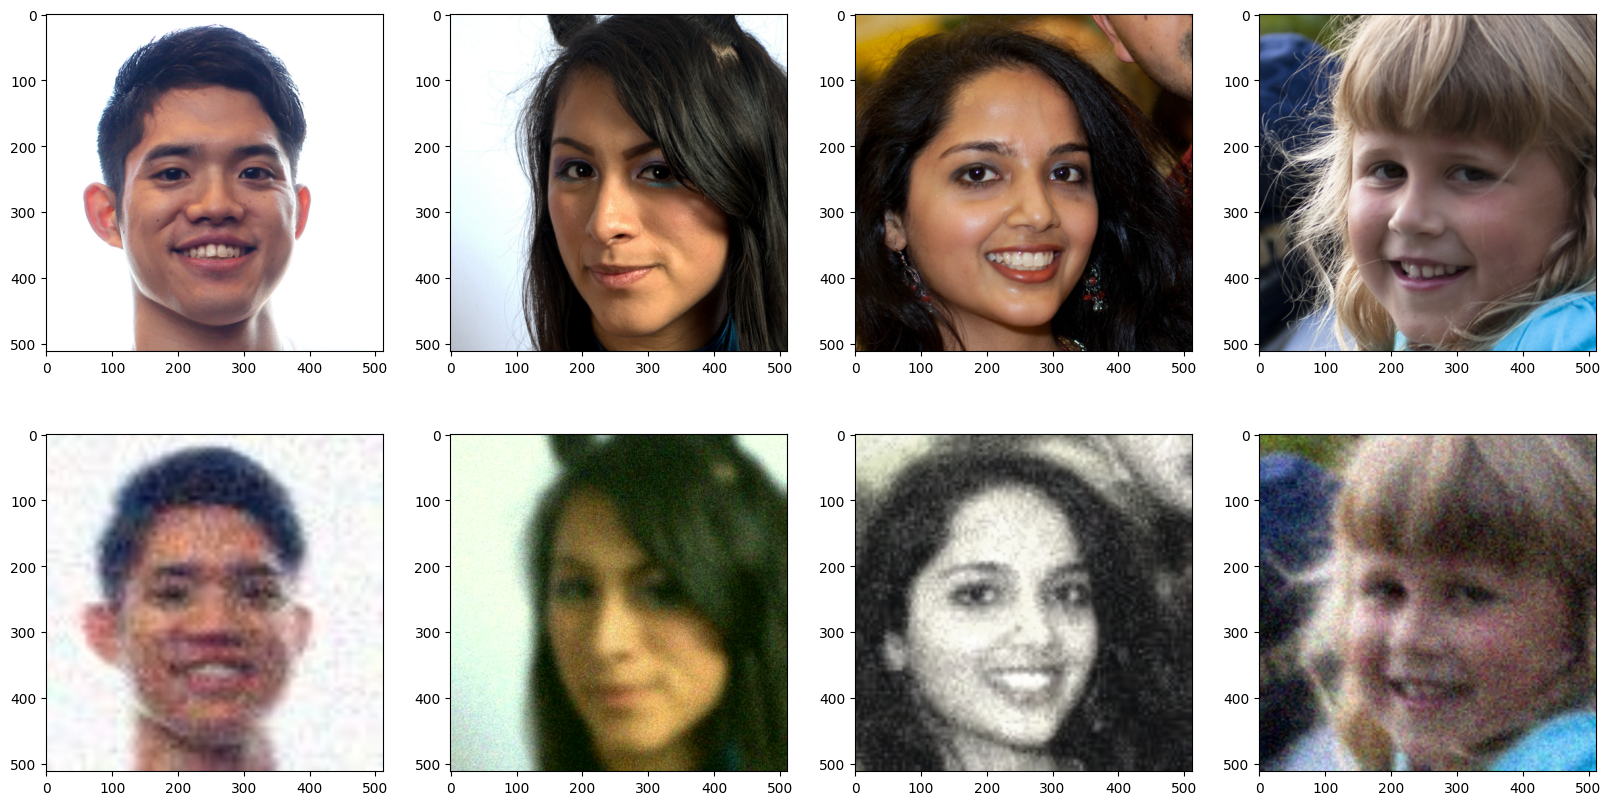

In [12]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots(2,4,figsize=(20,10))
for i in range(4):
    ax[0,i].imshow(hq_img[i].permute(1,2,0))
    ax[1,i].imshow(lq_img[i].permute(1,2,0))
plt.show()